## COD API, One Match --> explore API, format, clean & reshape, test some visualizations

In [1]:
import asyncio
import os
import sys
import dotenv
from pprint import pprint
import datetime
from datetime import datetime, timezone, timedelta
import pandas as pd
import numpy as np
import pickle
from itertools import product

import altair as alt

import callofduty
from callofduty import Mode, Platform, Title, TimeFrame, GameType, Language

In [2]:
# Using SSO
# We're storing our SSO token in an .env file stored locally to separate our config from code (w. python-dotenv). An.env-template file (with help to retrieve token) is provided for you to edit and populate the variable(s)
# callofduty.py client .Login() goes through all the authentification steps and initiate a session to access protected routes
# The client is asynchronous thus the 'await style'
from dotenv import load_dotenv
load_dotenv()
client = await callofduty.Login(sso=os.environ["SSO"])

In [3]:
# we're storing our strings conversion module above current working (notebooks) directory
sys.path.insert(0, os.path.abspath('../wzkd'))
import labels
from labels import MODES_LABELS, WEAPONS_CAT_PREFIX, WEAPONS_CAT, CW_WEAPONS_CAT_SUFFIX, WEAPONS_CAT_LABELS, WEAPONS_LABELS

In [4]:
import urllib.parse
from typing import List, Optional, Union

from callofduty.client import Client
from callofduty.http import HTTP
from callofduty.http import Request

async def GetMatchStats(
    self, platform, title: Title, mode: Mode, matchId: int, language: Language = Language.English, **kwargs
):
    """ 
    Compared to client : modified so that we do not use Platform.abc as parameter
    but instead our app-defined workflow (drop down menu) to select our platform of choice"
    """
    return (
        await self.http.GetFullMatch(
            title.value, platform, mode.value, matchId, language.value
        )
    )["data"]["allPlayers"]
    # api result, at very least for Warzone {'data':{'all_players:' is the only key},'status': call status}

Client.GetMatchStats = GetMatchStats
match = await client.GetMatchStats('battle', Title.ModernWarfare, Mode.Warzone, matchId=5010761031247628577)

# example of IDs :
# 16569868366653777065 : confetti_seeker : BR solo 
#5010761031247628577 : trios 
# 11672696746036290501 a "custom" mode game (Rumble Clash)
# 6825832239054239925 : Iron Trials Trios
# 9207377216339591388 : BR Duo

#### Option : save match to disk

In [5]:
#save file if you want to work in offline mode
with open("match.pkl", 'wb') as f:
    pickle.dump(match, f)

## Match result : structure

In [2]:
# load offline data
with open('match.pkl', 'rb') as f:
    match = pickle.load(f)

### Overview

In [7]:
raw = pd.DataFrame(match)
raw.head(5)

,utcStartSeconds,utcEndSeconds,map,mode,matchID,duration,playlistName,version,gameType,playerCount,playerStats,player,teamCount,rankedTeams,draw,privateMatch
0,1637275401,1637277038,mp_don4,br_brtrios,5010761031247628577,1637000,None,1,wz,151,"{'kills': 0.0, 'medalXp': 0.0, 'matchXp': 541....","{'team': 'team_forty', 'rank': 54.0, 'awards':...",53,None,False,False
1,1637275401,1637277038,mp_don4,br_brtrios,5010761031247628577,1637000,None,1,wz,151,"{'kills': 5.0, 'medalXp': 50.0, 'objectiveLast...","{'team': 'team_forty_four', 'rank': 54.0, 'awa...",53,None,False,False
2,1637275401,1637277038,mp_don4,br_brtrios,5010761031247628577,1637000,None,1,wz,151,"{'kills': 0.0, 'medalXp': 0.0, 'matchXp': 1355...","{'team': 'team_forty_three', 'rank': 54.0, 'aw...",53,None,False,False
3,1637275401,1637277038,mp_don4,br_brtrios,5010761031247628577,1637000,None,1,wz,151,"{'kills': 7.0, 'medalXp': 350.0, 'objectiveTea...","{'team': 'team_thirty_three', 'rank': 54.0, 'a...",53,None,False,False
4,1637275401,1637277038,mp_don4,br_brtrios,5010761031247628577,1637000,None,1,wz,151,"{'kills': 1.0, 'medalXp': 30.0, 'matchXp': 819...","{'team': 'team_thirty_six', 'rank': 54.0, 'awa...",53,None,False,False


### Focus on a single player 'row'

In [5]:
pprint(match[0:1], depth=10)

[{'draw': False,
  'duration': 1637000,
  'gameType': 'wz',
  'map': 'mp_don4',
  'matchID': '5010761031247628577',
  'mode': 'br_brtrios',
  'player': {'awards': {},
             'brMissionStats': {'missionStatsByType': {},
                                'missionsComplete': 0,
                                'totalMissionWeaponXpEarned': 0.0,
                                'totalMissionXpEarned': 0.0},
             'loadout': [{'extraPerks': [{'image': None,
                                          'imageMainUi': None,
                                          'imageProgression': None,
                                          'label': None,
                                          'name': 'specialty_covert_ops'},
                                         {'image': None,
                                          'imageMainUi': None,
                                          'imageProgression': None,
                                          'label': None,
                          

### 'playerStats' nested col

In [9]:
df = raw['playerStats'].apply(pd.Series)
df.head(5)

,kills,medalXp,matchXp,scoreXp,wallBangs,score,totalXp,headshots,assists,challengeXp,...,objectiveBrDownEnemyCircle4,objectiveBrDownEnemyCircle3,objectiveBrDownEnemyCircle2,objectiveBrDownEnemyCircle6,objectiveShieldDamage,objectiveBrDownEnemyCircle5,objectiveDestroyedVehicleMedium,objectiveMedalScoreKillSsRadarDrone,objectiveDestroyedEquipment,objectiveMedalScoreSsKillPrecisionAirstrike
0,0.0,0.0,541.0,0.0,0.0,0.0,541.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,50.0,8610.0,7970.0,0.0,5025.0,18902.0,2.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,13557.0,1825.0,0.0,825.0,15407.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7.0,350.0,12481.0,13500.0,0.0,10200.0,32477.0,2.0,2.0,0.0,...,1.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,30.0,8195.0,4625.0,0.0,4125.0,13165.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.keys()

Index(['kills', 'medalXp', 'matchXp', 'scoreXp', 'wallBangs', 'score',
       'totalXp', 'headshots', 'assists', 'challengeXp', 'rank',
       'scorePerMinute', 'distanceTraveled', 'teamSurvivalTime', 'deaths',
       'kdRatio', 'bonusXp', 'gulagDeaths', 'timePlayed', 'executions',
       'gulagKills', 'nearmisses', 'percentTimeMoving', 'miscXp',
       'longestStreak', 'teamPlacement', 'damageDone', 'damageTaken',
       'objectiveLastStandKill', 'objectiveMunitionsBoxTeammateUsed',
       'objectiveBrDownEnemyCircle1', 'objectiveBrMissionPickupTablet',
       'objectiveReviver', 'objectiveBrKioskBuy', 'objectiveBrCacheOpen',
       'objectiveTeamWiped', 'objectiveBrDownEnemyCircle4',
       'objectiveBrDownEnemyCircle3', 'objectiveBrDownEnemyCircle2',
       'objectiveBrDownEnemyCircle6', 'objectiveShieldDamage',
       'objectiveBrDownEnemyCircle5', 'objectiveDestroyedVehicleMedium',
       'objectiveMedalScoreKillSsRadarDrone', 'objectiveDestroyedEquipment',
       'objectiveMedalS

In [11]:
cols_set1 = [
    'kills',
    'medalXp',
    'score',
    'matchXp',
    'scoreXp',
    'scorePerMinute',
    'challengeXp',
    'totalXp'
]
cols_set2 = [
    'kills',
     'deaths',
     'assists',
     'kdRatio',
     'headshots',
     'percentTimeMoving',
     'nearmisses',
     'executions',
     'longestStreak',
     'damageDone',
     'damageTaken'
]
cols_set3 = [
    'kills',
    'timePlayed',
    'distanceTraveled',
    'teamSurvivalTime',
    'teamPlacement'
]
cols_set4 = [
    'kills',
    'objectiveTeamWiped',
    'objectiveLastStandKill',
    'objectiveBrDownEnemyCircle1',
    'objectiveBrDownEnemyCircle2',
    'objectiveBrDownEnemyCircle3',
    'objectiveBrDownEnemyCircle4',
    'objectiveBrDownEnemyCircle5',
    'objectiveBrDownEnemyCircle6',
]
cols_set5 = [
    'kills',
    'objectiveReviver',
    'objectiveBrMissionPickupTablet',
    'objectiveBrCacheOpen',
    'objectiveBrKioskBuy'
]
cols_set5  = [
    'kills',
    'objectiveMunitionsBoxTeammateUsed',
    'objectiveMedalScoreSsKillTomaStrike',
    'objectiveDestroyedVehicleHeavy',
    'objectiveDestroyedVehicleMedium'
]

In [12]:
for set_cols in [cols_set1, cols_set2, cols_set3, cols_set4, cols_set5]:
    # some colums (keys) not existing depending on gamemode /  or all values missing
    set_cols = [col for col in set_cols if col in df.columns.tolist()] 
    display(df[set_cols].sort_values('kills', ascending=False).head(10))

,kills,medalXp,score,matchXp,scoreXp,scorePerMinute,challengeXp,totalXp
124,15.0,705.0,12300.0,13885.0,16200.0,424.381829,0.0,38699.0
27,11.0,465.0,9275.0,12481.0,12300.0,382.737276,0.0,30033.0
18,10.0,855.0,8800.0,13740.0,11265.0,315.412186,0.0,33541.0
69,9.0,105.0,6325.0,11358.0,8025.0,289.915966,0.0,22282.0
96,9.0,305.0,4250.0,11893.0,5170.0,182.012848,0.0,20231.0
16,8.0,320.0,4375.0,7775.0,6275.0,304.878049,0.0,16973.0
138,7.0,270.0,11500.0,13885.0,15200.0,400.696864,0.0,33313.0
3,7.0,350.0,10200.0,12481.0,13500.0,421.197522,0.0,32477.0
44,7.0,330.0,6725.0,9795.0,9290.0,356.134157,0.0,23429.0
119,6.0,20.0,3775.0,13297.0,6215.0,136.692818,0.0,22187.0


,kills,deaths,assists,kdRatio,headshots,percentTimeMoving,nearmisses,executions,longestStreak,damageDone,damageTaken
124,15.0,2.0,2.0,7.500000,8.0,94.663280,0.0,0.0,7.0,5100.0,515.0
27,11.0,3.0,0.0,3.666667,3.0,78.717200,0.0,0.0,8.0,3931.0,830.0
18,10.0,1.0,1.0,10.000000,2.0,91.486664,0.0,0.0,11.0,3664.0,379.0
69,9.0,3.0,1.0,3.000000,3.0,83.739840,0.0,1.0,4.0,3158.0,719.0
96,9.0,4.0,0.0,2.250000,1.0,61.695683,0.0,0.0,5.0,3121.0,795.0
16,8.0,2.0,1.0,4.000000,0.0,79.081635,0.0,0.0,5.0,2025.0,400.0
138,7.0,2.0,1.0,3.500000,1.0,88.310036,0.0,0.0,7.0,2017.0,696.0
3,7.0,3.0,2.0,2.333333,2.0,87.099130,0.0,0.0,9.0,3535.0,448.0
44,7.0,2.0,1.0,3.500000,2.0,96.866100,0.0,0.0,9.0,2863.0,519.0
119,6.0,4.0,1.0,1.500000,1.0,68.615000,0.0,1.0,3.0,2610.0,870.0


,kills,timePlayed,distanceTraveled,teamSurvivalTime,teamPlacement
124,15.0,1739.0,400737.60,1590864.0,1.0
27,11.0,1454.0,255787.70,1379568.0,5.0
18,10.0,1674.0,477212.56,1590864.0,2.0
69,9.0,1309.0,257282.48,1240368.0,9.0
96,9.0,1401.0,299802.72,1303200.0,7.0
16,8.0,861.0,285602.62,767712.0,21.0
138,7.0,1722.0,381213.94,1590864.0,1.0
3,7.0,1453.0,256223.30,1379568.0,5.0
44,7.0,1133.0,211283.34,1062624.0,15.0
119,6.0,1657.0,216045.05,1551600.0,4.0


,kills,objectiveTeamWiped,objectiveLastStandKill,objectiveBrDownEnemyCircle1,objectiveBrDownEnemyCircle2,objectiveBrDownEnemyCircle3,objectiveBrDownEnemyCircle4,objectiveBrDownEnemyCircle5,objectiveBrDownEnemyCircle6
124,15.0,5.0,9.0,8.0,3.0,1.0,NaN,2.0,3.0
27,11.0,5.0,4.0,7.0,NaN,6.0,NaN,NaN,NaN
18,10.0,2.0,8.0,5.0,1.0,1.0,NaN,2.0,1.0
69,9.0,2.0,4.0,7.0,1.0,1.0,NaN,NaN,NaN
96,9.0,1.0,6.0,10.0,1.0,NaN,NaN,NaN,NaN
16,8.0,3.0,4.0,7.0,NaN,NaN,NaN,NaN,NaN
138,7.0,5.0,3.0,4.0,1.0,1.0,1.0,NaN,NaN
3,7.0,4.0,6.0,2.0,2.0,3.0,1.0,NaN,NaN
44,7.0,NaN,7.0,4.0,3.0,NaN,NaN,NaN,NaN
119,6.0,1.0,6.0,4.0,NaN,2.0,NaN,NaN,1.0


,kills,objectiveMunitionsBoxTeammateUsed,objectiveDestroyedVehicleMedium
124,15.0,NaN,NaN
27,11.0,NaN,NaN
18,10.0,2.0,NaN
69,9.0,NaN,NaN
96,9.0,NaN,NaN
16,8.0,NaN,NaN
138,7.0,NaN,NaN
3,7.0,NaN,NaN
44,7.0,1.0,NaN
119,6.0,NaN,NaN


Quick notes :</br>
- objectiveTeamWiped = teams wiped
- objectiveLastStandKil = kills when alone in team ?? ^_o

### 'player' multi nested col

In [13]:
df = raw['player'].apply(pd.Series)
df.head(5)

,team,rank,awards,username,uno,loadouts,brMissionStats,loadout,clantag
0,team_forty,54.0,{},MOMMA BOT,14316658672198631169,"[{'primaryWeapon': {'name': 'iw8_ar_kilo433', ...","{'missionsComplete': 0, 'totalMissionXpEarned'...","[{'primaryWeapon': {'name': 'iw8_ar_kilo433', ...",NaN
1,team_forty_four,54.0,"{'one_shot_kill': 352464.0, 'mode_x_eliminate'...",aak112,2663740102088488351,[{'primaryWeapon': {'name': 'iw8_ar_t9british'...,"{'missionsComplete': 0, 'totalMissionXpEarned'...",[{'primaryWeapon': {'name': 'iw8_ar_t9british'...,NaN
2,team_forty_three,54.0,{},Matteo_B1986,9067262784167753707,"[{'primaryWeapon': {'name': 'iw8_ar_galima', '...","{'missionsComplete': 0, 'totalMissionXpEarned'...","[{'primaryWeapon': {'name': 'iw8_ar_galima', '...",NaN
3,team_thirty_three,54.0,{},CarryDaTeam,8667473335152373421,"[{'primaryWeapon': {'name': 'iw8_ar_t9damage',...","{'missionsComplete': 0, 'totalMissionXpEarned'...","[{'primaryWeapon': {'name': 'iw8_ar_t9damage',...",NaN
4,team_thirty_six,54.0,{},KaliseDerretido,5828434415722207610,[{'primaryWeapon': {'name': 'iw8_ar_t9slowhand...,"{'missionsComplete': 1, 'totalMissionXpEarned'...",[{'primaryWeapon': {'name': 'iw8_ar_t9slowhand...,NaN


In [14]:
df.keys()

Index(['team', 'rank', 'awards', 'username', 'uno', 'loadouts',
       'brMissionStats', 'loadout', 'clantag'],
      dtype='object')

In [15]:
pprint(df['loadout'].apply(pd.Series)[0][0], depth=2)

{'extraPerks': [{...}, {...}, {...}],
 'killstreaks': [{...}, {...}, {...}],
 'lethal': {'image': None,
            'imageLarge': None,
            'label': None,
            'name': 'equip_at_mine',
            'progressionImage': None},
 'perks': [{...}, {...}, {...}],
 'primaryWeapon': {'attachments': [...],
                   'imageIcon': None,
                   'imageLoot': None,
                   'label': None,
                   'name': 'iw8_ar_kilo433',
                   'variant': '0'},
 'secondaryWeapon': {'attachments': [...],
                     'imageIcon': None,
                     'imageLoot': None,
                     'label': None,
                     'name': 'iw8_sm_t9capacity',
                     'variant': '0'},
 'tactical': {'image': None,
              'imageLarge': None,
              'label': None,
              'name': 'equip_hb_sensor',
              'progressionImage': None}}


In [16]:
pprint(df['loadouts'].apply(pd.Series)[0][0], depth=2)

{'extraPerks': [{...}, {...}, {...}],
 'killstreaks': [{...}, {...}, {...}],
 'lethal': {'image': None,
            'imageLarge': None,
            'label': None,
            'name': 'equip_at_mine',
            'progressionImage': None},
 'perks': [{...}, {...}, {...}],
 'primaryWeapon': {'attachments': [...],
                   'imageIcon': None,
                   'imageLoot': None,
                   'label': None,
                   'name': 'iw8_ar_kilo433',
                   'variant': '0'},
 'secondaryWeapon': {'attachments': [...],
                     'imageIcon': None,
                     'imageLoot': None,
                     'label': None,
                     'name': 'iw8_sm_t9capacity',
                     'variant': '0'},
 'tactical': {'image': None,
              'imageLarge': None,
              'label': None,
              'name': 'equip_hb_sensor',
              'progressionImage': None}}


In [17]:
df['brMissionStats'].apply(pd.Series).head(1)

,missionsComplete,totalMissionXpEarned,totalMissionWeaponXpEarned,missionStatsByType
0,0,0.0,0.0,{}


In [18]:
df['brMissionStats'].apply(pd.Series)[['missionStatsByType']]['missionStatsByType'].apply(pd.Series).head(10)

,scavenger,vip,timedrun,domination,assassination,blueprintextract
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,"{'weaponXp': 300.0, 'xp': 500.0, 'count': 1.0}",NaN,NaN,NaN,NaN,NaN
5,NaN,"{'weaponXp': 400.0, 'xp': 1000.0, 'count': 1.0}",NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN
7,"{'weaponXp': 300.0, 'xp': 500.0, 'count': 1.0}",NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN


### Functions to format Match result

In [19]:
def MatchPlayersToDf(match):
    """
    Convert Match result to a DataFrame we we can perform our aggregations nicely, later.
    Expand some entries (i.e player, playerstats) that are deeply nested.
    Filter out / retains columns.
    Built mainly to analyze a 'BR' match, but we made sure it should work for other match types
    
    Parameters
    ----------
    match : result from COD API "match" endpoint ; FYI formated as : 
        list[
                dict{ player 1 match stats },
                dict{ player 2 match stats },
                dict{ +- 150 players },
            ]
    
    Returns
    -------
    DataFrame, a match stats with players as rows, matches/player stats as columns/values
    """
    
    
    keep_cols =  [
        'mode',
        'utcEndSeconds',
        'team',
        'username',
        'timePlayed',
        'teamPlacement',
        'kdRatio', 
        'kills', 
        'deaths', 
        'assists', 
        'damageDone',
        'damageTaken',
        'gulagKills',
        'percentTimeMoving',
        'duration'
        ]
    
    df = pd.DataFrame(match)
    
    # column playerStats is a series of dict, we can expand it easily and append, then drop the original
    df = pd.concat([df.drop(['playerStats'], axis=1), df['playerStats'].apply(pd.Series)], axis=1)
    
    # colum 'player' has more depth
    # once expanded, it has a column 'loadout' : a series of list of dict (either one or more, we will max 3)
    # and also brMissionStats (mostly empty ?, a col only present in BR matches) that we aren't interested in
    
    df = pd.concat([df.drop(['player'], axis=1), df['player'].apply(pd.Series)], axis=1)
    if 'brMissionStats' in df.columns:
        df = df.drop(['brMissionStats'], axis = 1)
    df = pd.concat([df.drop(['loadout'], axis=1), df['loadout'].apply(pd.Series)], axis=1)
    for col in range(0,3):
        if col in df.columns:
            df[col] = df[col].apply(lambda x: f"{x['primaryWeapon']['name']} - {x['secondaryWeapon']['name']}" if not str(x) == 'nan' else np.nan)
            col_name = "loadout_" + str(col +1)
            df = df.rename(columns={col: f"loadout_{str(col +1)}"})   
            keep_cols.append(col_name)
    
    # Ensure we are not throwing an error if we want to keep a column that does not exist (i.e. not in a BR match) :
    keep_cols = [col for col in keep_cols if col in df.columns.tolist()]
    
    return df[keep_cols]

In [20]:
with open('match.pkl', 'rb') as f:
    match = pickle.load(f)

In [21]:
df_match = MatchPlayersToDf(match)
df_match.head(3)

,mode,utcEndSeconds,team,username,timePlayed,teamPlacement,kdRatio,kills,deaths,assists,damageDone,damageTaken,gulagKills,percentTimeMoving,duration,loadout_1,loadout_2,loadout_3
0,br_brtrios,1637277038,team_forty,MOMMA BOT,83.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.666670,1637000,iw8_ar_kilo433 - iw8_sm_t9capacity,iw8_pi_t9semiauto - iw8_fists,NaN
1,br_brtrios,1637277038,team_forty_four,aak112,964.0,18.0,2.5,5.0,2.0,0.0,1729.0,221.0,1.0,91.525420,1637000,iw8_ar_t9british - iw8_sm_t9cqb,NaN,NaN
2,br_brtrios,1637277038,team_forty_three,Matteo_B1986,1659.0,3.0,0.0,0.0,4.0,1.0,198.0,818.0,0.0,69.567986,1637000,iw8_ar_galima - iw8_sm_t9heavy,iw8_ar_t9damage - iw8_fists,iw8_lm_t9light - iw8_sm_mpapa5


In [22]:
df_match[df_match['username'] == 'Confetti_Seeker']

,mode,utcEndSeconds,team,username,timePlayed,teamPlacement,kdRatio,kills,deaths,assists,damageDone,damageTaken,gulagKills,percentTimeMoving,duration,loadout_1,loadout_2,loadout_3


In [23]:
def MatchPlayersStandardize(df):
    """
    A first layer of standadization (as properly formated) to our a "Match with players stats" DataFrame
    For further aggregations / better readibility of our data
    
    Returns
    -------
    DataFrame : players/teams as rows, cleaned player stats of a given match as columns
    """
    
    int_cols =  [
        'teamPlacement', 
        'kills', 
        'deaths', 
        'assists', 
        'gulagKills', 
        'damageDone',
        'damageTaken'
        ]
    
    float_cols = [
        'kdRatio',
        'percentTimeMoving'
        ]
    
    ts_cols = [
        'utcEndSeconds'
        ]
    
    columns_labels = {
        'utcEndSeconds':'Ended at',
        'timePlayed': 'Playtime',
        'teamPlacement':'#',
        'kdRatio':'KD',
        'damageDone':'Damage >',
        'damageTaken':'Damage <',
        'gulagKills':'Gulag',
        'headshots':'% headshots',
        'percentTimeMoving':'% moving',
        'duration':'Game duration'
        }

    # Ensure we are not throwing an error if we want to keep a column that does not exist (i.e. not in a BR match) :
    int_cols = [col for col in int_cols if col in df.columns.tolist()]
    
    # df = df.fillna(0)
    # generic conversions/rounding for int and float cols
    df[int_cols] = df[int_cols].astype(int)
    df[float_cols] = df[float_cols].astype(float).round(1) # still renders 0.0000 in streamlit but ugly hacks exists
    
    # specials : timestamp, loadout columns, match type...
    df.team = df.team.apply(lambda x: x.replace("team_", ""))
    df['utcEndSeconds'] = df['utcEndSeconds'].apply(lambda x: datetime.fromtimestamp(x))
    
    df['duration'] = df['duration'].apply(lambda x: x/1000).apply(lambda x: pd.to_datetime(x, unit='s').strftime('%M')) # API duration is in seconds x1000
    df['timePlayed'] = df['timePlayed'].apply(lambda x: pd.to_datetime(x, unit='s').strftime('%M:%S')) # API timePlayed is in seconds
    if 'gulagKills' in df.columns.tolist():
        df.loc[df['mode'].isin(MODES_LABELS['battle_royale']), 'gulagKills'] = df.loc[df['mode'].isin(MODES_LABELS['battle_royale']), 'gulagKills'].map({1:'W', 0:'L'})
        df['gulagKills'].replace(0, '-', inplace=True)
    for col in ['loadout_1', 'loadout_2', 'loadout_3']:
            df.fillna({col:'-'}, inplace=True) if col in df.columns else None
    
    for label_cat in ['battle_royale', 'multiplayer']:
        df = df.replace({"mode": MODES_LABELS[label_cat]})
    df = df.rename(columns=columns_labels)
    df.columns = df.columns.str.capitalize()
    df = df.rename({"Kd":"KD"}, axis=1)
     
    return df

In [24]:
df_match = MatchPlayersToDf(match)
df = MatchPlayersStandardize(df_match)
df.tail(3)

,Mode,Ended at,Team,Username,Playtime,#,KD,Kills,Deaths,Assists,Damage >,Damage <,Gulag,% moving,Game duration,Loadout_1,Loadout_2,Loadout_3
148,Trios,2021-11-19 00:10:38,thirty,VeeDawg,18:56,16,1.0,2,2,2,766,575,W,91.4,27,iw8_sm_t9cqb - iw8_me_t9sai,iw8_pi_t9semiauto - iw8_fists,-
149,Trios,2021-11-19 00:10:38,twenty_three,cassa_17,21:44,8,0.5,1,2,0,491,560,L,52.6,27,iw8_ar_t9damage - iw8_sm_t9spray,iw8_pi_t9semiauto - iw8_fists,-
150,Trios,2021-11-19 00:10:38,seventeen,b3lamafia,21:49,9,2.5,5,2,2,1694,571,W,95.1,27,iw8_ar_t9slowhandling - iw8_sm_t9handling,-,-


In [25]:
df[df['Username'] == "Confetti_Seeker"]

,Mode,Ended at,Team,Username,Playtime,#,KD,Kills,Deaths,Assists,Damage >,Damage <,Gulag,% moving,Game duration,Loadout_1,Loadout_2,Loadout_3


### Retrieve some matche basic infos

In [26]:
def retrieveTeam(df, gamertag):
    """ --> df, Retrieve team name of given gamertag"""    
    return df[df["Username"] == gamertag]['Team'].tolist()[0]  

def retrieveTeammates(df, gamertag):
    """ --> df, Retrieve list of gamertag + his teammates"""  
    team = retrieveTeam(df, gamertag)
    return df[df["Team"] == team]['Username'].tolist()

def retrieveDate(df):
    """ --> str, Retrieve end date (str) of our match """   
    return df['Ended at'][0].strftime('%Y-%m-%d %H:%M')

def retrievePlacement(df, gamertag):
    """ --> int, Retrieve final placement of a player/his team """  
    return df[df["Username"] == gamertag]["#"].tolist()[0]

def retrievePlayerKills(df, gamertag):
    """ --> dict, Retrieve Player Kills kpis"""
    return df[df["Username"] == gamertag][["KD", "Kills", "Deaths"]].to_dict('records')[0]

In [27]:
df.head()

,Mode,Ended at,Team,Username,Playtime,#,KD,Kills,Deaths,Assists,Damage >,Damage <,Gulag,% moving,Game duration,Loadout_1,Loadout_2,Loadout_3
0,Trios,2021-11-19 00:10:38,forty,MOMMA BOT,01:23,52,0.0,0,0,0,0,0,L,91.7,27,iw8_ar_kilo433 - iw8_sm_t9capacity,iw8_pi_t9semiauto - iw8_fists,-
1,Trios,2021-11-19 00:10:38,forty_four,aak112,16:04,18,2.5,5,2,0,1729,221,W,91.5,27,iw8_ar_t9british - iw8_sm_t9cqb,-,-
2,Trios,2021-11-19 00:10:38,forty_three,Matteo_B1986,27:39,3,0.0,0,4,1,198,818,L,69.6,27,iw8_ar_galima - iw8_sm_t9heavy,iw8_ar_t9damage - iw8_fists,iw8_lm_t9light - iw8_sm_mpapa5
3,Trios,2021-11-19 00:10:38,thirty_three,CarryDaTeam,24:13,5,2.3,7,3,2,3535,448,L,87.1,27,iw8_ar_t9damage - iw8_sn_kilo98,iw8_ar_t9fasthandling - iw8_fists,-
4,Trios,2021-11-19 00:10:38,thirty_six,KaliseDerretido,14:20,19,0.3,1,3,1,212,409,W,89.4,27,iw8_ar_t9slowhandling - iw8_pi_decho,iw8_pi_t9semiauto - iw8_fists,iw8_pi_t9semiauto - iw8_fists


In [30]:
gamertag = "gentil_renard"# "gentil_renard"
team = retrieveTeam(df, gamertag)
teammates = retrieveTeammates(df, gamertag)
print(team, teammates)

twenty_seven ['nicoyzovitch', 'gentil_renard', 'Moinolol']


In [31]:
placement = retrievePlacement(df, gamertag)
placement

11

In [32]:
player_kills = retrievePlayerKills(df, gamertag)
player_kills

{'KD': 0.2, 'Kills': 1, 'Deaths': 4}

### Sandbox Weapons cleaning

In [33]:
WEAPONS_CAT_PREFIX = ['iw8_']
WEAPONS_CAT = ["ar", "lm", "sm", "pi", "sn", "la", "sh", "me"]
CW_WEAPONS_CAT_SUFFIX = ['_t9']

WEAPONS_CAT_LABELS = {
    'ar':'Ar',
    'lm':'Lmg',
    'sm':'Smg',
    'pi':'Pistol',
    'sn':'Sniper',
    'la':'Launcher',
    'sh':'Shotgun',
    'me':'Melee'
}

WEAPONS_LABELS = {
    'ar_falima': 'FAL',
    'ar_mcharlie': 'M13',
    'ar_mike4': 'M4A1',
    'ar_sierra552': 'Grau 5.56',
    'ar_t9british': 'EM2',
    'ar_t9damage': 'AK-47 cw',
    'ar_t9fastfire': 'FFAR',
    'ar_t9season6': 'ground AR',
    'ar_t9slowfire': 'C58',
    'ar_t9slowhandling': 'Fara83',
    'ar_t9standard': 'XM4',
    'ar_tango21': 'RAM-7',
    'ar_valpha': 'ASVAL',
    'la_gromeo': 'Pila',
    'la_kgolf': 'Strela',
    'la_rpapa7': 'RPG-7 mw',
    'la_t9freefire': 'RPG-7 cw',
    'la_t9season6': 'ground launcher',
    'lm_t9fastfire': 'MG82',
    'lm_t9light': 'RPD',
    'lm_t9season6': 'ground lmg?',
    'me_riotshield': 'Shield',
    'me_t9machete': 'Machete',
    'me_t9sai': 'Sai',
    'pi_t9burst': 'Diamatti',
    'pi_t9season6': 'ground pistol',
    'pi_mike1911':'M19',
    'pi_t9semiauto': 'Pistol',
    'sh_aalpha12': 'JAK-12',
    'sh_dpapa12': 'R9-0',
    'sh_t9season6': 'ground shotgun',
    'sm_t9semiauto': 'TEC-9',
    'sm_mpapa7': 'MP7',
    'sm_mpapa5': 'MP5 mw',
    'sm_t9accurate': 'LC10',
    'sm_t9capacity': 'Bullfrog',
    'sm_t9cqb': 'OTs 9',
    'sm_t9fastfire': 'MAC-10',
    'sm_t9handling': 'Milano',
    'sm_t9season6': 'ground smg',
    'sm_t9spray': 'ppsh',
    'sm_t9standard': 'MP5 cw',
    'sm_t9heavy': 'AK-74u',
    'sm_uzulu': 'UZI',
    'sn_alpha50': 'AX-50',
    'sn_cannon': 'ZRG',
    'sn_hdromeo': 'HDR',
    'sn_kilo98': 'Kar98',
    'sn_romeo700': 'SP-R',
    'sn_t9accurate': 'K31',
    'sn_t9powersemi': 'M82',
    'sn_t9season6': 'ground sniper'
    }

WEAPONS_LABELS = dict(sorted(WEAPONS_LABELS.items()))

In [34]:
WEAPONS_LABELS

{'ar_falima': 'FAL',
 'ar_mcharlie': 'M13',
 'ar_mike4': 'M4A1',
 'ar_sierra552': 'Grau 5.56',
 'ar_t9british': 'EM2',
 'ar_t9damage': 'AK-47 cw',
 'ar_t9fastfire': 'FFAR',
 'ar_t9season6': 'ground AR',
 'ar_t9slowfire': 'C58',
 'ar_t9slowhandling': 'Fara83',
 'ar_t9standard': 'XM4',
 'ar_tango21': 'RAM-7',
 'ar_valpha': 'ASVAL',
 'la_gromeo': 'Pila',
 'la_kgolf': 'Strela',
 'la_rpapa7': 'RPG-7 mw',
 'la_t9freefire': 'RPG-7 cw',
 'la_t9season6': 'ground launcher',
 'lm_t9fastfire': 'MG82',
 'lm_t9light': 'RPD',
 'lm_t9season6': 'ground lmg?',
 'me_riotshield': 'Shield',
 'me_t9machete': 'Machete',
 'me_t9sai': 'Sai',
 'pi_mike1911': 'M19',
 'pi_t9burst': 'Diamatti',
 'pi_t9season6': 'ground pistol',
 'pi_t9semiauto': 'Pistol',
 'sh_aalpha12': 'JAK-12',
 'sh_dpapa12': 'R9-0',
 'sh_t9season6': 'ground shotgun',
 'sm_mpapa5': 'MP5 mw',
 'sm_mpapa7': 'MP7',
 'sm_t9accurate': 'LC10',
 'sm_t9capacity': 'Bullfrog',
 'sm_t9cqb': 'OTs 9',
 'sm_t9fastfire': 'MAC-10',
 'sm_t9handling': 'Milano',


In [35]:
# load offline data
open_file = open("match.pkl", "rb")
match = pickle.load(open_file)
df_match = MatchPlayersToDf(match)
df = MatchPlayersStandardize(df_match)
open_file.close()

In [36]:
date = retrieveDate(df)
date

'2021-11-19 00:10'

In [38]:
df[df['Username'] == 'gentil_renard']

,Mode,Ended at,Team,Username,Playtime,#,KD,Kills,Deaths,Assists,Damage >,Damage <,Gulag,% moving,Game duration,Loadout_1,Loadout_2,Loadout_3
63,Trios,2021-11-19 00:10:38,twenty_seven,gentil_renard,21:48,11,0.2,1,4,1,948,932,L,74.4,27,iw8_ar_valpha - iw8_sn_t9accurate,iw8_ar_t9season6 - iw8_fists,-


In [39]:
loadouts = df.Loadout_1.values.tolist()
loadouts[0:20]

['iw8_ar_kilo433 - iw8_sm_t9capacity',
 'iw8_ar_t9british - iw8_sm_t9cqb',
 'iw8_ar_galima - iw8_sm_t9heavy',
 'iw8_ar_t9damage - iw8_sn_kilo98',
 'iw8_ar_t9slowhandling - iw8_pi_decho',
 'iw8_sm_t9cqb - iw8_sn_kilo98',
 'iw8_ar_mcharlie - iw8_sn_kilo98',
 'iw8_sm_t9cqb - iw8_sn_t9accurate',
 'iw8_ar_mcharlie - iw8_sn_t9accurate',
 'iw8_ar_t9slowhandling - iw8_sm_t9fastfire',
 'iw8_sm_t9cqb - iw8_ar_t9slowfire',
 'iw8_ar_anovember94 - iw8_knife',
 'iw8_sn_kilo98 - iw8_pi_t9burst',
 '-',
 'iw8_ar_t9damage - iw8_sm_t9cqb',
 'iw8_lm_mgolf36 - iw8_sh_t9fullauto',
 'iw8_ar_t9slowfire - iw8_sm_mpapa5',
 'iw8_sm_t9fastfire - iw8_sn_kilo98',
 'iw8_ar_t9british - iw8_pi_t9burst',
 'iw8_ar_t9standard - iw8_sn_t9quickscope']

In [40]:
def convertWeapons(x):
    """ Clean Loadouts (weapons) columns, particul. using labels.py """
    
    # Cold War weapons format is iw8_sm_t9, iw8_ar_t9 etc. for Cold War,  Modern Warfare : iw8_ar, iw8_me etc. for MW
    if not x == "-":
        x = x.split(" - ")
        x = list(map(lambda weapon: weapon.replace(WEAPONS_CAT_PREFIX[0], ''), x))
        x = list(map(lambda weapon: WEAPONS_LABELS.get(weapon) or weapon, x))
        
        # After a won Gulag you (usually) spawn with 'fists' and season weapon (usually Pistols); remove 'fists'
        if 'fists' in x:
            x = list(map(lambda weapon: weapon.replace('fists', ''), x))
            x = x[0]
        else:
            x = ' - '.join(x)
    else:
        x = '-'
    return x

In [41]:
lw = [
    '-',
    'iw8_sm_t9season6 - iw8_pi_t9burst',
    'iw8_ar_sierra552 - iw8_sm_t9season6',
    'iw8_ar_t9season6 - iw8_sn_t9powersemi',
    'iw8_pi_t9semiauto - fists'
]

for string in lw:
    weapons = convertWeapons(string)
    print(weapons)

-
ground smg - Diamatti
Grau 5.56 - ground smg
ground AR - M82
Pistol


### Extract/calculate some specific KPI's

In [42]:
team = retrieveTeam(df, gamertag)
keep_cols = ['Username', 'KD', 'Kills', 'Deaths', 'Assists'] + df.columns[df.columns.str.startswith('Loadout')].tolist()
df_team = df[df["Team"] == team][keep_cols]

# add Team aggregated stats final row
agg_func = {
    "KD":"sum",
    "Kills":"sum",
    "Deaths":"sum",
    "Assists":"sum"
}

team_kd = (df_team.Kills.sum() / df_team.Deaths.sum()).round(1)
row_total = df_team.agg(agg_func).to_dict()

row_total.update({'Username': 'Team'})
row_total.update({'KD': team_kd})
df_team = df_team.append(row_total, ignore_index=True)
df_team[['Kills', 'Deaths', 'Assists']] = df_team[['Kills', 'Deaths', 'Assists']].astype(int)
df_team

,Username,KD,Kills,Deaths,Assists,Loadout_1,Loadout_2,Loadout_3
0,nicoyzovitch,1.3,4,3,0,iw8_lm_t9fastfire - iw8_sm_t9cqb,iw8_pi_t9semiauto - iw8_fists,iw8_pi_t9semiauto - iw8_fists
1,gentil_renard,0.2,1,4,1,iw8_ar_valpha - iw8_sn_t9accurate,iw8_ar_t9season6 - iw8_fists,-
2,Moinolol,2.5,5,2,0,iw8_sn_t9accurate - iw8_sm_t9fastfire,iw8_pi_t9semiauto - iw8_fists,-
3,Team,1.1,10,9,1,NaN,NaN,NaN


In [43]:
df_team

,Username,KD,Kills,Deaths,Assists,Loadout_1,Loadout_2,Loadout_3
0,nicoyzovitch,1.3,4,3,0,iw8_lm_t9fastfire - iw8_sm_t9cqb,iw8_pi_t9semiauto - iw8_fists,iw8_pi_t9semiauto - iw8_fists
1,gentil_renard,0.2,1,4,1,iw8_ar_valpha - iw8_sn_t9accurate,iw8_ar_t9season6 - iw8_fists,-
2,Moinolol,2.5,5,2,0,iw8_sn_t9accurate - iw8_sm_t9fastfire,iw8_pi_t9semiauto - iw8_fists,-
3,Team,1.1,10,9,1,NaN,NaN,NaN


In [44]:
def teamKills(df, gamertag):
    """ Return a DataFrame with Team players and team total KD, K/D/A ; also Loadouts """
    
    team = retrieveTeam(df, gamertag)
    keep_cols = ['Username', 'KD', 'Kills', 'Deaths', 'Assists'] + df.columns[df.columns.str.startswith('Loadout')].tolist()
    df_team = df[df["Team"] == team][keep_cols].sort_values('Kills', ascending=False)
    
    # add Team aggregated stats final row
    agg_func = {
        "KD":"sum",
        "Kills":"sum",
        "Deaths":"sum",
        "Assists":"sum"
    }
    
    team_kd = (df_team.Kills.sum() / df_team.Deaths.sum()).round(1)
    row_total = df_team.agg(agg_func).to_dict()
    
    row_total.update({'Username': 'Team'})
    row_total.update({'KD': team_kd})
    df_team = df_team.append(row_total, ignore_index=True)
    df_team[['Kills', 'Deaths', 'Assists']] = df_team[['Kills', 'Deaths', 'Assists']].astype(int)
    df_team.fillna('-', inplace=True)

    # Convert COD weapons code names, using labels.py , convertWeapons()
    for col in df_team.columns[df_team.columns.str.startswith('Loadout')]:
        df_team[col] = df_team[col].map(lambda x: convertWeapons(x))
    return df_team

def topPlayers(df):
    """ Return a DataFrame with match top 5 players ranked by Kills, KD """
    keep_cols = ['Username', 'Team', 'KD', 'Kills', 'Deaths', 'Assists'] + df.columns[df.columns.str.startswith('Loadout')].tolist()
    df_top = df.sort_values(by="Kills",ascending=False)[0:5][keep_cols]

    for col in df_top.columns[df_top.columns.str.startswith('Loadout')]:
        df_top[col] = df_top[col].map(lambda x: convertWeapons(x))
    return df_top

def teamKillsPlacement(df, gamertag):
    """ Retrieve final placement according to # kills, of a player/his team """ 
    index = df.groupby('Team')[['Kills']].sum().sort_values('Kills', ascending = False).reset_index()
    condition = index['Team'] == retrieveTeam(df, gamertag)
    return index[condition]['Kills'].index.tolist()[0]

def playersQuartiles(df):
    """ All players, mean and median, quartiles """
    return df[['Kills', 'KD']].describe().to_dict()

In [66]:
# load offline data
with open('match.pkl', 'rb') as f:
    match = pickle.load(f)
df_match = MatchPlayersToDf(match)
df = MatchPlayersStandardize(df_match)
open_file.close()

In [67]:
df.head(1)

,Mode,Ended at,Team,Username,Playtime,#,KD,Kills,Deaths,Assists,Damage >,Damage <,Gulag,% moving,Game duration,Loadout_1,Loadout_2,Loadout_3
0,Trios,2021-11-19 00:10:38,forty,MOMMA BOT,01:23,52,0.0,0,0,0,0,0,L,91.7,27,iw8_ar_kilo433 - iw8_sm_t9capacity,iw8_pi_t9semiauto - iw8_fists,-


In [68]:
team_kills = teamKills(df, gamertag)
team_kills

,Username,KD,Kills,Deaths,Assists,Loadout_1,Loadout_2,Loadout_3
0,Moinolol,2.5,5,2,0,K31 - MAC-10,Pistol,-
1,nicoyzovitch,1.3,4,3,0,MG82 - OTs 9,Pistol,Pistol
2,gentil_renard,0.2,1,4,1,ASVAL - K31,ground AR,-
3,Team,1.1,10,9,1,-,-,-


In [69]:
players_quartiles = playersQuartiles(df)
players_quartiles

{'Kills': {'count': 151.0,
  'mean': 2.0596026490066226,
  'std': 2.4879222605204,
  'min': 0.0,
  '25%': 0.0,
  '50%': 1.0,
  '75%': 3.0,
  'max': 15.0},
 'KD': {'count': 151.0,
  'mean': 0.9814569536423841,
  'std': 1.3093206367430876,
  'min': 0.0,
  '25%': 0.0,
  '50%': 0.5,
  '75%': 1.5,
  'max': 10.0}}

In [70]:
tkp = teamKillsPlacement(df, gamertag)
tkp

10

In [71]:
players_kills = topPlayers(df)
players_kills

,Username,Team,KD,Kills,Deaths,Assists,Loadout_1,Loadout_2,Loadout_3
124,DeadlyXhen,twenty,7.5,15,2,2,Milano - EM2,Pistol,sh_t9pump
27,Cunny-Boss,thirty_three,3.7,11,3,0,AK-47 cw - OTs 9,Pistol,MAC-10 - pi_papa320
18,GaelJMG,twenty_five,10.0,10,1,1,EM2 - Diamatti,Pistol,-
69,DonEleganza,seventeen,3.0,9,3,1,ar_akilo47 - sn_xmike109,Pistol,Pistol
96,n1ce,twelve,2.2,9,4,0,K31 - MAC-10,Pistol,OTs 9


In [72]:
def shrinkDf(df, cols_to_concat, str_join, new_col):
    """ For our df to occupy less space in Streamlit : to str + concat given cols into 1"""
    
    def concat_cols(df, cols_to_concat, str_join):
        return pd.Series(map(str_join.join, df[cols_to_concat].values.tolist()),index = df.index)
    
    for col in cols_to_concat:
        df[col] = df[col].astype(str)
    df[new_col] = concat_cols(df, cols_to_concat, str_join)
    df = df.drop(cols_to_concat, axis=1)
    
    return df

def removeEmptyLoadouts(x):
    """ Remove empty loadout after concatenation"""
    x = x.split(', ')
    x = list(map(lambda weapon: weapon.replace('-', '') if len(weapon) <= 1 else weapon, x))
    x = list(filter(None, x))
    return ', '.join(x)

def renderTeam(team_kills):
    """ Render Team KDA concat with Team Weapons, in a plotly table"""

    team_kills = shrinkDf(team_kills, cols_to_concat=['Kills', 'Deaths', 'Assists'], str_join=' | ', new_col= 'K D A')
    cols_to_concat = team_kills.columns[team_kills.columns.str.startswith('Loadout')].tolist()
    team_kills = shrinkDf(team_kills, cols_to_concat, str_join=', ', new_col='Loadouts')
    
    team_kills = team_kills.rename(columns={"Username": "Player"})
    
    return team_kills

def renderPlayers(players_kills):
    """ Render Team KDA concat with Team Weapons, in a plotly table"""

    players_kills = shrinkDf(players_kills, cols_to_concat=['Kills', 'Deaths', 'Assists'], str_join=' | ', new_col= 'K D A')
    cols_to_concat = players_kills.columns[players_kills.columns.str.startswith('Loadout')].tolist()
    players_kills = shrinkDf(players_kills, cols_to_concat, str_join=', ', new_col='Loadouts')
    
    players_kills = players_kills.rename(columns={"Username": "Player"})
    
    return players_kills

def removeEmptyStrings(x):
    """ Remove empty strings "-" mainy left after concatenation operations or fillna"""
    x = x.split(', ')
    x = list(map(lambda weapon: weapon.replace('-', '') if len(weapon) <= 1 else weapon, x))
    x = list(filter(None, x))
    return ', '.join(x)

In [73]:
team_info = renderTeam(team_kills)
team_info

,Player,KD,K D A,Loadouts
0,Moinolol,2.5,5 | 2 | 0,"K31 - MAC-10, Pistol, -"
1,nicoyzovitch,1.3,4 | 3 | 0,"MG82 - OTs 9, Pistol, Pistol"
2,gentil_renard,0.2,1 | 4 | 1,"ASVAL - K31, ground AR, -"
3,Team,1.1,10 | 9 | 1,"-, -, -"


In [74]:
team_info['Loadouts'] = team_info['Loadouts'].map(lambda x : removeEmptyStrings(x))
team_info

,Player,KD,K D A,Loadouts
0,Moinolol,2.5,5 | 2 | 0,"K31 - MAC-10, Pistol"
1,nicoyzovitch,1.3,4 | 3 | 0,"MG82 - OTs 9, Pistol, Pistol"
2,gentil_renard,0.2,1 | 4 | 1,"ASVAL - K31, ground AR"
3,Team,1.1,10 | 9 | 1,


In [75]:
players_kills = topPlayers(df)
display(players_kills)
top_players = renderPlayers(players_kills)
top_players

,Username,Team,KD,Kills,Deaths,Assists,Loadout_1,Loadout_2,Loadout_3
124,DeadlyXhen,twenty,7.5,15,2,2,Milano - EM2,Pistol,sh_t9pump
27,Cunny-Boss,thirty_three,3.7,11,3,0,AK-47 cw - OTs 9,Pistol,MAC-10 - pi_papa320
18,GaelJMG,twenty_five,10.0,10,1,1,EM2 - Diamatti,Pistol,-
69,DonEleganza,seventeen,3.0,9,3,1,ar_akilo47 - sn_xmike109,Pistol,Pistol
96,n1ce,twelve,2.2,9,4,0,K31 - MAC-10,Pistol,OTs 9


,Player,Team,KD,K D A,Loadouts
124,DeadlyXhen,twenty,7.5,15 | 2 | 2,"Milano - EM2, Pistol, sh_t9pump"
27,Cunny-Boss,thirty_three,3.7,11 | 3 | 0,"AK-47 cw - OTs 9, Pistol, MAC-10 - pi_papa320"
18,GaelJMG,twenty_five,10.0,10 | 1 | 1,"EM2 - Diamatti, Pistol, -"
69,DonEleganza,seventeen,3.0,9 | 3 | 1,"ar_akilo47 - sn_xmike109, Pistol, Pistol"
96,n1ce,twelve,2.2,9 | 4 | 0,"K31 - MAC-10, Pistol, OTs 9"


### Visualizations sandbox

#### Using Altair vega

In [76]:
# load offline data
with open('match.pkl', 'rb') as f:
    match = pickle.load(f)
df_match = MatchPlayersToDf(match)
df = MatchPlayersStandardize(df_match)
df.head(2)

,Mode,Ended at,Team,Username,Playtime,#,KD,Kills,Deaths,Assists,Damage >,Damage <,Gulag,% moving,Game duration,Loadout_1,Loadout_2,Loadout_3
0,Trios,2021-11-19 00:10:38,forty,MOMMA BOT,01:23,52,0.0,0,0,0,0,0,L,91.7,27,iw8_ar_kilo433 - iw8_sm_t9capacity,iw8_pi_t9semiauto - iw8_fists,-
1,Trios,2021-11-19 00:10:38,forty_four,aak112,16:04,18,2.5,5,2,0,1729,221,W,91.5,27,iw8_ar_t9british - iw8_sm_t9cqb,-,-


In [77]:
base = alt.Chart(df)         
hist2 = base.mark_bar().encode(
    x=alt.X('Kills:Q', bin=alt.BinParams(step=1)),
    y=alt.Y('count()', axis=alt.Axis(format='', title='n Players')),
    tooltip=['Kills'],
    color=alt.value("orange")

).properties(width=400, height=300)         
red_median_line = base.mark_rule(color='red').encode(
    x=alt.X('median(Kills):Q', title='Kills'),
    size=alt.value(3)
)
hist2 + red_median_line

alt.LayerChart(...)

In [78]:
base = alt.Chart(df)

hist2 = base.mark_bar().encode(
    x=alt.X('Kills:Q', bin=alt.BinParams(step=1)),
    y=alt.Y('count()', axis=alt.Axis(tickCount=10, format='', title='n Players')),
    tooltip=['Kills', 'count()'],
    color=alt.value("orange")
            
).properties(width=400, height=200)

red_median_line = base.mark_rule(color='black').encode(
    x=alt.X('median(KD):Q', title='KD'),
    size=alt.value(2)
)

hist2 + red_median_line

alt.LayerChart(...)

In [79]:
hist2 = base.mark_bar().encode(
    x=alt.X('KD:Q', bin=alt.Bin(step=0.5)), 
    y=alt.Y('count()', axis=alt.Axis(format='', title='n Players')),
    tooltip=['KD', 'count()'],
    color=alt.value("orange")
            
).properties(width=400, height=300)

red_median_line2 = base.mark_rule(color='black').encode(
    x=alt.X('median(KD):Q', title='KD'),
    size=alt.value(2)
)
hist2 + red_median_line2

alt.LayerChart(...)

#### Using Plotly

##### Tables

In [80]:
import plotly.graph_objects as go

In [81]:
team_info

,Player,KD,K D A,Loadouts
0,Moinolol,2.5,5 | 2 | 0,"K31 - MAC-10, Pistol"
1,nicoyzovitch,1.3,4 | 3 | 0,"MG82 - OTs 9, Pistol, Pistol"
2,gentil_renard,0.2,1 | 4 | 1,"ASVAL - K31, ground AR"
3,Team,1.1,10 | 9 | 1,


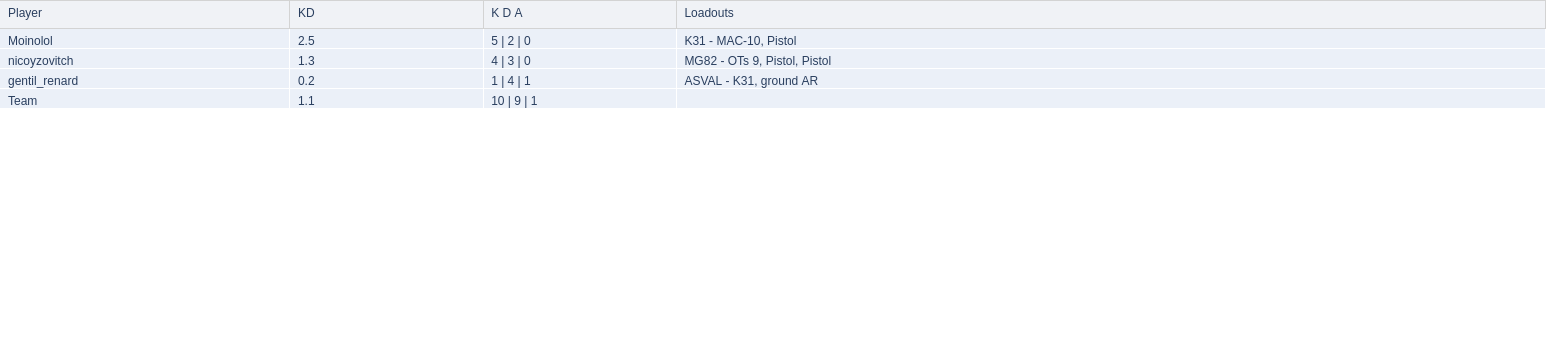

In [82]:
df = team_info

fig = go.Figure(
    data=[
        go.Table(
            columnwidth = [30, 20, 20, 90],
            header = dict(values=list(df.columns),
                          align=['left'],
                          line_color='lightgray',
                          fill_color='#F0F2F6'),
            cells = dict(values=[df.Player, df.KD, df['K D A'], df.Loadouts],
                         align='left'))
    ]
)

# to narrow spaces between several figures
fig.update_layout(
    width=600,
    height=250,
    margin=dict(
        l=0,
        r=1,
        b=0,
        t=0
        )
    )
fig.show()

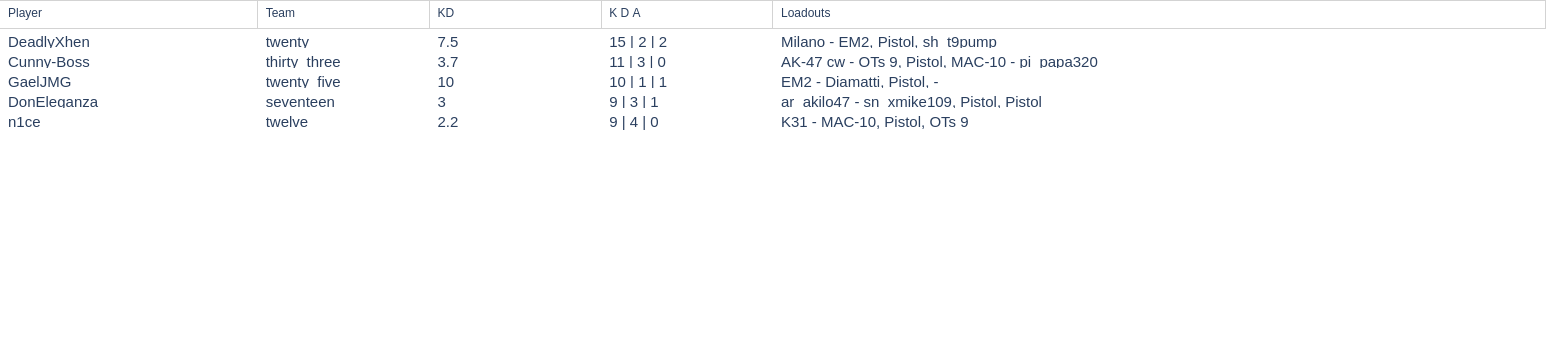

In [83]:
df = top_players

fig = go.Figure(
    data=[
        go.Table(
            columnwidth = [30, 20, 20, 20, 90],
            header = dict(values=list(df.columns),
                          align=['left'],
                          line_color='lightgray',
                          fill_color='white'),
            cells = dict(values=[df.Player, df.Team, df.KD, df['K D A'], df.Loadouts],
                         align='left',
                         fill_color='white', font_size=15))
    ]
)

# to narrow spaces between several figures
fig.update_layout(
    width=1000,
    height=250,
    margin=dict(
        l=0,
        r=1,
        b=0,
        t=0
        )
    )
fig.show()

##### Bullet chart

In [84]:
players_quartiles

{'Kills': {'count': 151.0,
  'mean': 2.0596026490066226,
  'std': 2.4879222605204,
  'min': 0.0,
  '25%': 0.0,
  '50%': 1.0,
  '75%': 3.0,
  'max': 15.0},
 'KD': {'count': 151.0,
  'mean': 0.9814569536423841,
  'std': 1.3093206367430876,
  'min': 0.0,
  '25%': 0.0,
  '50%': 0.5,
  '75%': 1.5,
  'max': 10.0}}

In [85]:
open_file = open("match.pkl", "rb")
match = pickle.load(open_file)
open_file.close()
df_match = MatchPlayersToDf(match)
df = MatchPlayersStandardize(df_match)
df.head(2)

players_quartiles = playersQuartiles(df)
print('players quartiles: ')
for k, v in players_quartiles.items():
    print(k,v)
player_kills = retrievePlayerKills(df, gamertag)
print('player kills: ', player_kills)
# kpis = ProfileGetKpis(profile)
# player_kd = kpis['br_kd']
lifetime_kd = 0.62
lifetime_kills_ratio = 1.9
print('lifetime kd: ', lifetime_kd)

players quartiles: 
Kills {'count': 151.0, 'mean': 2.0596026490066226, 'std': 2.4879222605204, 'min': 0.0, '25%': 0.0, '50%': 1.0, '75%': 3.0, 'max': 15.0}
KD {'count': 151.0, 'mean': 0.9814569536423841, 'std': 1.3093206367430876, 'min': 0.0, '25%': 0.0, '50%': 0.5, '75%': 1.5, 'max': 10.0}
player kills:  {'KD': 0.2, 'Kills': 1, 'Deaths': 4}
lifetime kd:  0.62


#### single bullet chart

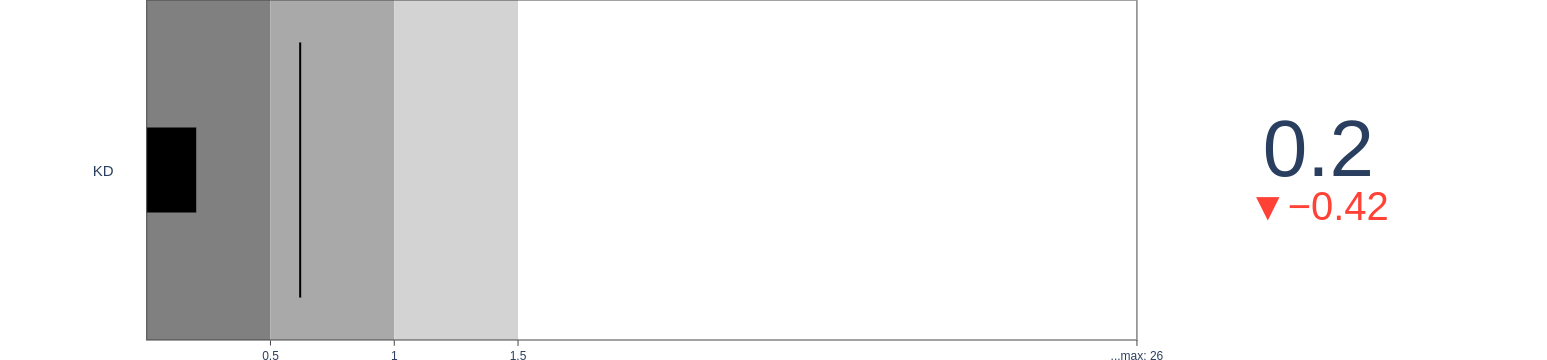

In [86]:
# matche's values
kd_player = player_kills['KD'] if not player_kills['KD'] == 0 else 0.1
kd_mean = round(players_quartiles['KD']['mean'], 1)
kd_median = round(players_quartiles['KD']['50%'],1)
kd_Q3 = round(players_quartiles['KD']['75%'],1)
kd_max = round(players_quartiles['KD']['max'],1)
gauge_length = 4

fig = go.Figure(go.Indicator(
    mode = "number+gauge+delta", value = kd_player,
    domain = {'x': [0.1, 1], 'y': [0, 1]},
    title = {'text' :"KD", 'font_size':15},
    delta = {'reference': lifetime_kd},
    gauge = {
        'shape': "bullet",
        'axis': {'range': [None, gauge_length]},
        'threshold': {
            'line': {'color': "black", 'width': 2},
            'thickness': 0.75,
            'value': lifetime_kd},
        'steps': [
            {'range': [0, kd_median], 'color': "grey"},
            {'range': [kd_median, kd_mean], 'color': "darkgrey"},
            {'range': [kd_mean, kd_Q3], 'color': "lightgrey"}],
        'bar': {'color': "black"}
    }))


fig.update_layout(
    height = 70,
    width = 600,
    margin = {'t':0, 'b':20, 'l':0}
)
ticks = [kd_median, kd_mean, kd_Q3, gauge_length]
fig.update_traces(
    gauge={
        "axis": {
            "tickmode": "array",
            "tickvals": ticks,
            "ticktext": ["...max: 26" if i == gauge_length else i for i in ticks],
        }
    }
)
fig.show()

#### multiple bullet charts

In [87]:
# matche's values
# readify some variables to make our operations more explicit
kd_player = player_kills['KD'] if not player_kills['KD'] == 0 else 0.1
kd_mean = round(players_quartiles['KD']['mean'], 1)
kd_median = round(players_quartiles['KD']['50%'],1)
kd_Q3 = round(players_quartiles['KD']['75%'],1)
kd_max = round(players_quartiles['KD']['max'],1)


kills_player = player_kills['Kills'] if not player_kills['KD'] == 0 else 0.1
kills_mean = round(players_quartiles['Kills']['mean'], 1)
kills_median = round(players_quartiles['Kills']['50%'],1)
kills_Q3 = round(players_quartiles['Kills']['75%'],1)
kills_max = round(players_quartiles['Kills']['max'],1)

len_gauge_kd = 4
len_gauge_kills = 4

In [88]:
kills_player

1

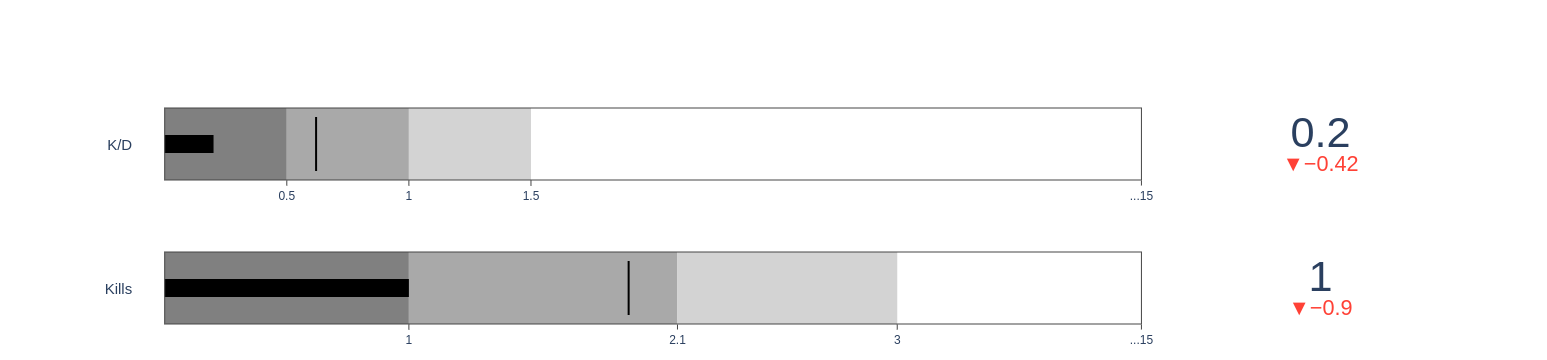

In [89]:
fig = go.Figure()

# plot kd bullet chart
ticks = [kd_median, kd_mean, kd_Q3, len_gauge_kd]

fig.add_trace(go.Indicator(
    mode = "number+gauge+delta", value = kd_player,
    domain = {'x': [0.1, 1], 'y': [0.5, 0.7]},
    title = {'text' :"K/D", 'font_size':15},
    delta = {'reference': lifetime_kd},
    gauge = {
        'shape': "bullet",
        'axis': {
            'range': [None, len_gauge_kd],
            'tickmode':'array',
            'tickvals':ticks,
            'ticktext':[f"...{int(kills_max)}" if i == len_gauge_kd else i for i in ticks]
        },
        'threshold': {
            'line': {'color': "black", 'width': 2},
            'thickness': 0.75,
            'value': lifetime_kd},
        'steps': [
            {'range': [0, kd_median], 'color': "grey"},
            {'range': [kd_median, kd_mean], 'color': "darkgrey"},
            {'range': [kd_mean, kd_Q3], 'color': "lightgrey"}],
        'bar': {'color': "black"}
    }))

# plot kills bullet chart
ticks = [kills_median, kills_mean, kills_Q3, len_gauge_kills]

fig.add_trace(go.Indicator(
    mode = "number+gauge+delta", value = kills_player,
    domain = {'x': [0.1, 1], 'y': [0.1, 0.3]},
    title = {'text' :"Kills", 'font_size':15},
    delta = {'reference': lifetime_kills_ratio},
    gauge = {
        'shape': "bullet",
        'axis': {
            'range': [None, len_gauge_kills],
            'tickmode':'array',
            'tickvals':ticks,
            'ticktext':[f"...{int(kills_max)}" if i == len_gauge_kills else i for i in ticks]
        },
        'threshold': {
            'line': {'color': "black", 'width': 2},
            'thickness': 0.75,
            'value': lifetime_kills_ratio},
        'steps': [
            {'range': [0, kills_median], 'color': "grey"},
            {'range': [kills_median, kills_mean], 'color': "darkgrey"},
            {'range': [kills_mean, kills_Q3], 'color': "lightgrey"}],
        'bar': {'color': "black"}
    }))


fig.update_layout(
    height = 200,
    width = 600,
    margin = {'t':0, 'b':0, 'l':20}
)

fig.show()

#### Sankey / Flow Chart tests

In [90]:
# model

In [91]:
# load offline data
with open('match.pkl', 'rb') as f:
    match = pickle.load(f)
match = pd.DataFrame(match)
display(match.head(1))
print(match.keys())

,utcStartSeconds,utcEndSeconds,map,mode,matchID,duration,playlistName,version,gameType,playerCount,playerStats,player,teamCount,rankedTeams,draw,privateMatch
0,1637275401,1637277038,mp_don4,br_brtrios,5010761031247628577,1637000,None,1,wz,151,"{'kills': 0.0, 'medalXp': 0.0, 'matchXp': 541....","{'team': 'team_forty', 'rank': 54.0, 'awards':...",53,None,False,False


Index(['utcStartSeconds', 'utcEndSeconds', 'map', 'mode', 'matchID',
       'duration', 'playlistName', 'version', 'gameType', 'playerCount',
       'playerStats', 'player', 'teamCount', 'rankedTeams', 'draw',
       'privateMatch'],
      dtype='object')


In [92]:
# Build our players kills etc data

player_col = match['player'].apply(pd.Series)
player_stats_col = match['playerStats'].apply(pd.Series)

keep_cols = [
    'username',
    'team',
    'duration',
    'teamSurvivalTime',
    'timePlayed',  
    'teamPlacement',
    'kills',
    'objectiveBrDownEnemyCircle1',
    'objectiveBrDownEnemyCircle2',
    'objectiveBrDownEnemyCircle3',
    'objectiveBrDownEnemyCircle4',
    'objectiveBrDownEnemyCircle5',
    'objectiveBrDownEnemyCircle6'
]

In [94]:
df = pd.concat([match, player_col, player_stats_col], axis = 1)[keep_cols]
display(df.sort_values('kills', ascending = False).head(3))
display(df.sort_values('teamPlacement', ascending = True).head(9))

#df['duration'] = df['duration'].apply(lambda x: x/1000).apply(lambda x: pd.to_datetime(x, unit='s').strftime('%M'))
#display(df.groupby('team'.agg('sum')))

,username,team,duration,teamSurvivalTime,timePlayed,teamPlacement,kills,objectiveBrDownEnemyCircle1,objectiveBrDownEnemyCircle2,objectiveBrDownEnemyCircle3,objectiveBrDownEnemyCircle4,objectiveBrDownEnemyCircle5,objectiveBrDownEnemyCircle6
124,DeadlyXhen,team_twenty,1637000,1590864.0,1739.0,1.0,15.0,8.0,3.0,1.0,NaN,2.0,3.0
27,Cunny-Boss,team_thirty_three,1637000,1379568.0,1454.0,5.0,11.0,7.0,NaN,6.0,NaN,NaN,NaN
18,GaelJMG,team_twenty_five,1637000,1590864.0,1674.0,2.0,10.0,5.0,1.0,1.0,NaN,2.0,1.0


,username,team,duration,teamSurvivalTime,timePlayed,teamPlacement,kills,objectiveBrDownEnemyCircle1,objectiveBrDownEnemyCircle2,objectiveBrDownEnemyCircle3,objectiveBrDownEnemyCircle4,objectiveBrDownEnemyCircle5,objectiveBrDownEnemyCircle6
138,THEFATHER,team_twenty,1637000,1590864.0,1722.0,1.0,7.0,4.0,1.0,1.0,1.0,NaN,NaN
124,DeadlyXhen,team_twenty,1637000,1590864.0,1739.0,1.0,15.0,8.0,3.0,1.0,NaN,2.0,3.0
92,platinium12345,team_twenty,1637000,1590864.0,1739.0,1.0,4.0,2.0,NaN,1.0,NaN,1.0,NaN
140,Titatan so garso,team_twenty_five,1637000,1590864.0,1685.0,2.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN
18,GaelJMG,team_twenty_five,1637000,1590864.0,1674.0,2.0,10.0,5.0,1.0,1.0,NaN,2.0,1.0
125,TT10only,team_twenty_five,1637000,1590864.0,1684.0,2.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN
2,Matteo_B1986,team_forty_three,1637000,1581120.0,1659.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,DamiaNik93,team_forty_three,1637000,1581120.0,1669.0,3.0,3.0,2.0,NaN,NaN,NaN,NaN,1.0
85,bLaCk_HooD,team_forty_three,1637000,1581120.0,1675.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Models

link: {'source': [0, 0, 1, 1, 0], 'target': [2, 3, 4, 5, 4], 'value': [8, 2, 2, 8, 4]}
node: {'label': ['ZERO', 'ONE', 'TWO', 'THREE', 'FOUR', 'FIVE'], 'pad': 50, 'thickness': 5}
data: Sankey({
    'link': {'source': [0, 0, 1, 1, 0], 'target': [2, 3, 4, 5, 4], 'value': [8, 2, 2, 8, 4]},
    'node': {'label': ['ZERO', 'ONE', 'TWO', 'THREE', 'FOUR', 'FIVE'], 'pad': 50, 'thickness': 5}
})


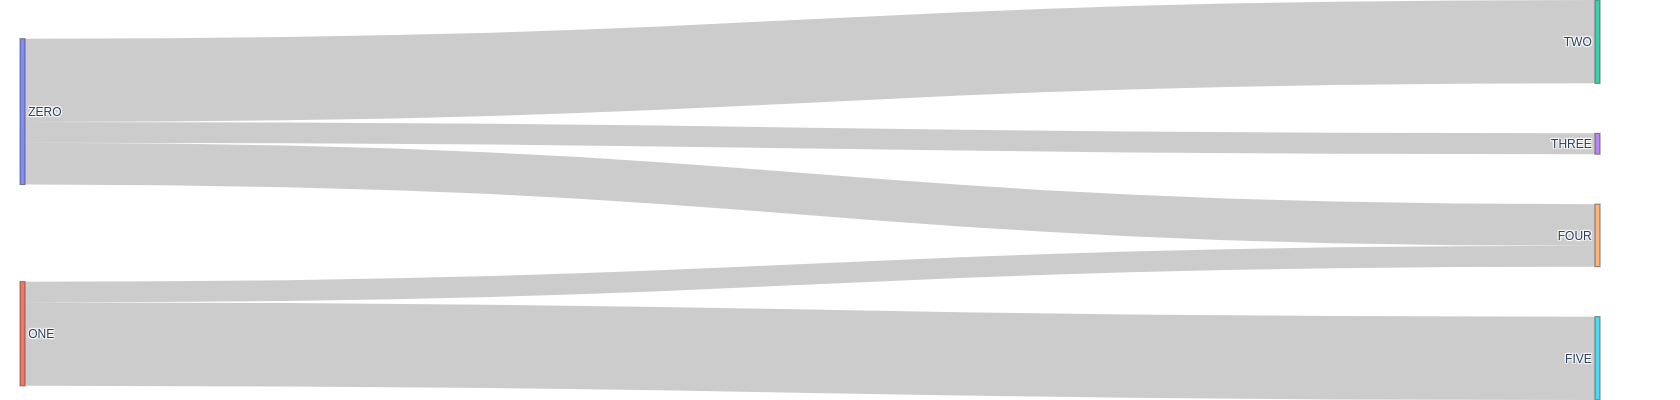

In [95]:
# data

label = ["ZERO", "ONE", "TWO", "THREE", "FOUR", "FIVE"]
source = [0, 0, 1, 1, 0]
target = [2, 3, 4, 5, 4]
value = [8, 2, 2, 8, 4]

# data to dict, dict to sankey

link = dict(source = source, target = target, value = value)
print(f"link: {link}")

node = dict(label = label, pad=50, thickness=5)
print(f"node: {node}")

data = go.Sankey(link = link, node=node)
print(f"data: {data}")

# plot

fig = go.Figure(data)
fig.update_layout(
    height = 400,
    width = 800,
    margin = {'t':0, 'b':0, 'l':20}
)

fig.show()

In [ ]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["A1", "A2", "B1", "B2", "C1", "C2"],
      color = "blue"
    ),
    link = dict(
      source = [0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 3, 3, 4, 4, 5],
      value = [8, 4, 2, 8, 4, 2]
  ))])

fig.update_layout(
    title_text="Basic Sankey Diagram",
    font_size=10,
    height = 200,
    width = 800,
    margin = {'t':0, 'b':0, 'l':20})
fig.show()